In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy

# Adding library directory to python search path
import sys
import git
repo = git.Repo('.', search_parent_directories=True)
library_dir = repo.working_tree_dir + '/lib'
sys.path.insert(0, library_dir)

import miptlib as mipt

# Create directory for generated .tex and .pdf
if not os.path.exists('gen'):
    os.mkdir('gen')

In [2]:
class consts:
    pi = 3.141592
    c  = 3 * 10**8 # m/s
    mu_0 = 4 * pi * 10**-7 # N * A^-2
    e = 1.6 * 10**-19 # C

    k = 1.38 * 10**-23 # J/K

class cgs:
    k = 1.38 * 10**-16 # erg/K
    e = 4.8 * 10**-10 # Franklin

class setup:
    dummy = 0

    Cu_sigma = 5 * 10**7 # Sm/m
    h = 1.5 * 10**-3 # m
    a = 45 * 10**-3 # m
    

In [3]:
f = 1/(2 * consts.pi) * 2 / (setup.Cu_sigma * consts.mu_0 * setup.h ** 2)
f * 15

f = 0.5 * f
for i in range(0, 20):
    print("{:.0f}0".format(f/10))
    f = f * 1.2

1130
1350
1620
1950
2330
2800
3360
4030
4840
5810
6970
8360
10040
12050
14450
17350
20810
24980
29970
35970


## Data

In [4]:
data = mipt.read_excel('data/371.ods', usecols=('A', 'B', 'C',
                                                'E', 'F', 'G', 'J', 'K',
                                                'L', 'M', 'N', 'Q', 'R'), header=(0, 1)).dropna(how='all')

xsl = {
    "nu, Hz" : "nu",
    "U, mV" : "U",
    "I, mA" : "I"
}

print("!\n!\n! Be careful with real values of phi. They can differ to 'phi + pi', 'pi - phi' or any another pi-way...\n"
      "! In this lab corrected values are 'ph'\n!\n!")

data = mipt.map_excel(data, xsl)
data

!
!
! Be careful with real values of phi. They can differ to 'phi + pi', 'pi - phi' or any another pi-way...
! In this lab corrected values are 'ph'
!
!


Low freq               Middle freq                                     \
         nu      I      U          nu       I      U       phi        ph   
0      20.0  438.8  134.5       100.0  395.78  528.4  1.256636  1.884954   
1      30.0  436.6  198.7       120.0  384.52  585.5  0.897597  2.243993   
2      40.0  432.5  259.5       140.0  374.07  629.5  0.872664  2.268926   
3      50.0  427.3  315.8       160.0  365.06  663.7  0.785397  2.356193   
4      60.0  421.4  367.6       180.0  357.33  690.5  0.729298  2.412292   
5      70.0  415.2  414.7       200.0  350.69  710.6  0.785397  2.356193   
6      80.0  408.8  457.0       300.0  329.10  765.2  0.739198  2.402392   
7      90.0  402.5  495.0       400.0  316.81  780.9  0.628318  2.513272   
8     100.0  396.3  528.6       500.0  307.96  781.4  0.314159  2.827431   
9     110.0  390.3  555.8       600.0  300.38  774.6  0.149600  2.991990   
10    120.0  384.6  584.8       700.0  293.27  763.9  0.174533  2.967057   
11      NaN    NaN    NaN       800.0  286.20  750.2  0.000000  3.141590   
12      NaN    NaN    NaN       900.0  279.09  734.6  0.000000  3.141590   
13      NaN    NaN    NaN      1000.0  271.95  717.8  0.000000  3.141590   
14      NaN    NaN    NaN      1100.0  264.80  700.3  0.000000  3.141590   
15      NaN    NaN    NaN         NaN     NaN    NaN       NaN       NaN   
16      NaN    NaN    NaN         NaN     NaN    NaN       NaN       NaN   
17      NaN    NaN    NaN         NaN     NaN    NaN       NaN       NaN   
18      NaN    NaN    NaN         NaN     NaN    NaN       NaN       NaN   

   High freq                                      
          nu        I      U       phi        ph  
0     1130.0  262.480  695.7  0.000000  3.141590  
1     1350.0  246.850  655.5  0.000000  3.141590  
2     1620.0  228.410  606.8  0.196349  3.337939  
3     1950.0  207.630  550.9  0.241661  3.383251  
4     2330.0  186.530  493.4  0.356999  3.498589  
5     2800.0  164.460  432.7  0.436332  3.577922  
6     3360.0  143.180  373.7  0.523598  3.665188  
7     4030.0  123.280  318.1  0.523598  3.665188  
8     4840.0  105.000  266.7  0.753982  3.895572  
9     5810.0   88.730  220.7  0.747998  3.889588  
10    6970.0   74.470  180.2  0.872664  4.014254  
11    8360.0   62.150  145.1  1.047197  4.188787  
12   10040.0   51.240  115.2  1.256636  4.398226  
13   12050.0   41.207   89.5  1.570795  4.712385  
14   14450.0   33.000   70.0  1.663195  4.804785  
15   17350.0   25.540   54.7  2.019594  5.161184  
16   20810.0   18.690   43.4  2.094393  5.235983  
17   24980.0   12.160   35.5  2.356193  5.497782  
18   29970.0    5.840   30.2  2.587192  5.728782

## Low frequences

In [5]:
data_low = data['Low freq'].dropna(how='all')

xi = data_low['U'] / (data_low['nu'] * data_low['I'])
data_low.insert(3, 'xi', xi)
data_low

,nu,I,U,xi
0,20.0,438.8,134.5,0.015326
1,30.0,436.6,198.7,0.015170
2,40.0,432.5,259.5,0.015000
3,50.0,427.3,315.8,0.014781
4,60.0,421.4,367.6,0.014539
5,70.0,415.2,414.7,0.014269
6,80.0,408.8,457.0,0.013974
7,90.0,402.5,495.0,0.013665
8,100.0,396.3,528.6,0.013338
9,110.0,390.3,555.8,0.012946


xi_0 = 0.0154
sigma = 2.174e+07


,<x>,sx,<y>,sy,rxy,a,da,b,db
0,5900.0,20380000.0,5050.857032,408116.163434,2.883152e+06,0.14147,0.001138,4216.186082,8.457468


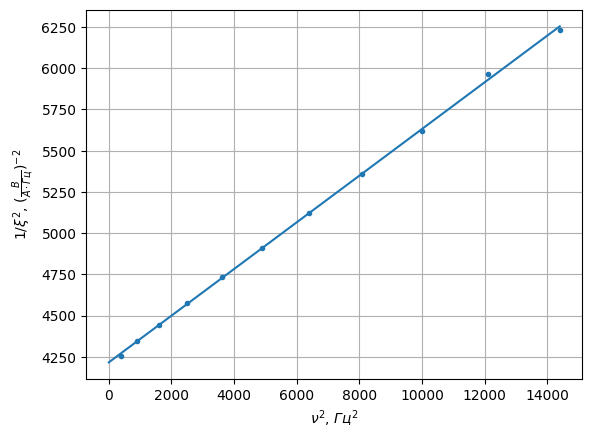

In [6]:

x = data_low['nu'] ** 2
y = 1 / data_low['xi']**2

mipt.plot(x, y, x_min=0)

plt.xlabel(r"$\nu^2$, $Гц^2$")
plt.ylabel(r"$1 / \xi^2$, $(\frac{В}{А \cdot Гц})^{-2}$")
plt.grid(True)

mnk_dat = mipt.mnk(x, y)

xi_0 = 1 / (mnk_dat.get_data()['b'][0] ** 0.5)
print("xi_0 = {:.4g}".format(xi_0))

k = mnk_dat.get_data()['a'][0]

sigma_low = k**0.5 * (2 * xi_0) / (setup.a * setup.h * consts.mu_0 * 2 * consts.pi)
print("sigma = {:.4g}".format(sigma_low))

# plt.legend()
plt.savefig("gen/xi-2_nu2.pdf")

mnk_dat.get_data()

In [7]:
data_mid = data['Middle freq'].dropna(how='all')
data_mid


,nu,I,U,phi,ph
0,100.0,395.78,528.4,1.256636,1.884954
1,120.0,384.52,585.5,0.897597,2.243993
2,140.0,374.07,629.5,0.872664,2.268926
3,160.0,365.06,663.7,0.785397,2.356193
4,180.0,357.33,690.5,0.729298,2.412292
5,200.0,350.69,710.6,0.785397,2.356193
6,300.0,329.10,765.2,0.739198,2.402392
7,400.0,316.81,780.9,0.628318,2.513272
8,500.0,307.96,781.4,0.314159,2.827431
9,600.0,300.38,774.6,0.149600,2.991990


## Middle frequences

cu_sigma = 2.413e+07


,<x>,sx,<y>,sy,rxy,a,da,b,db
0,150.0,1166.666667,0.846746,0.06598,7.501449,0.00643,0.00195,-0.117726,0.300009


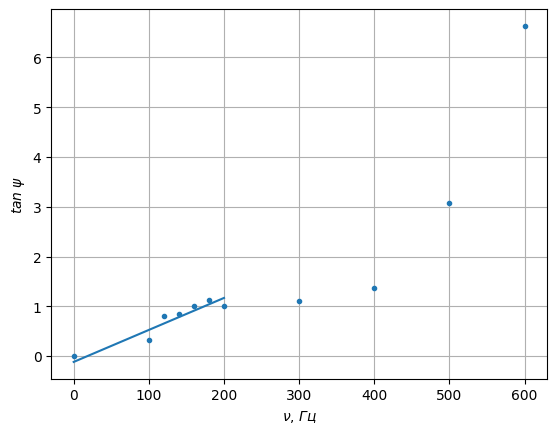

In [8]:
x = data_mid['nu'][0:10]
y = np.tan(data_mid['ph'][0:10] - consts.pi / 2)

# Why not?
tmp = pd.Series(0)
x = pd.concat([tmp, x], ignore_index=True)
y = pd.concat([tmp, y], ignore_index=True)

x_clean, y_clean, equ = mipt.plot(x, y, x_min=0, begin=1, end=6)

plt.xlabel(r"$\nu$, $Гц$")
plt.ylabel(r"$tan \; \psi$")
plt.grid(True)

mnk_dat = mipt.mnk(x_clean, y_clean)

# xi_0 = 1 / (mnk_dat.get_data()['b'][0] ** 0.5)
# print("xi_0 = {:.4g}".format(xi_0))

k = mnk_dat.get_data()['a'][0]

sigma_mid = k / (setup.a * setup.h * consts.mu_0 * consts.pi)
print("cu_sigma = {:.4g}".format(sigma_mid))

# plt.legend()
plt.savefig("gen/tanpsi_nu.pdf")

mnk_dat.get_data()

## High frequences

In [9]:
data_high = data['High freq'].dropna(how='all')
data_high


,nu,I,U,phi,ph
0,1130.0,262.480,695.7,0.000000,3.141590
1,1350.0,246.850,655.5,0.000000,3.141590
2,1620.0,228.410,606.8,0.196349,3.337939
3,1950.0,207.630,550.9,0.241661,3.383251
4,2330.0,186.530,493.4,0.356999,3.498589
5,2800.0,164.460,432.7,0.436332,3.577922
6,3360.0,143.180,373.7,0.523598,3.665188
7,4030.0,123.280,318.1,0.523598,3.665188
8,4840.0,105.000,266.7,0.753982,3.895572
9,5810.0,88.730,220.7,0.747998,3.889588


cu_sigma = 3.913e+07


,<x>,sx,<y>,sy,rxy,a,da,b,db
0,92.063505,1625.487544,1.917653,0.569314,30.30579,0.018644,0.000419,0.20121,0.042151


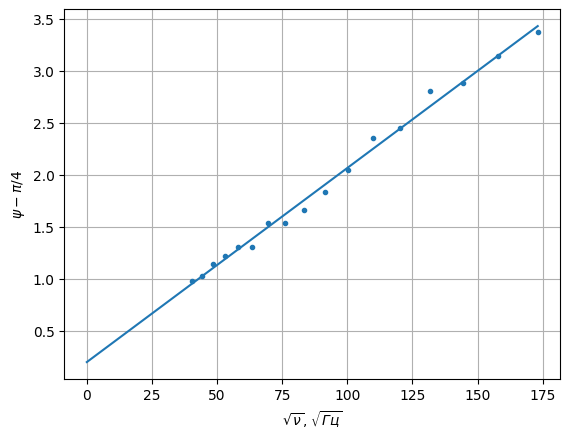

In [10]:
x = data_high['nu'][2:] ** 0.5
y = data_high['ph'][2:] - consts.pi / 2 - consts.pi / 4

x = x.reset_index(drop=True)
y = y.reset_index(drop=True)
# Why not?
# tmp = pd.Series(0)
# x = pd.concat([tmp, x], ignore_index=True)
# y = pd.concat([tmp, y], ignore_index=True)

x_clean, y_clean, equ = mipt.plot(x, y, x_min=0)

plt.xlabel(r"$\sqrt{\nu}$, $\sqrt{Гц}$")
plt.ylabel(r"$\psi - \pi / 4$")
plt.grid(True)

mnk_dat = mipt.mnk(x_clean, y_clean)

k = mnk_dat.get_data()['a'][0]

sigma_high = k**2 / (setup.h**2 * consts.mu_0 * consts.pi)
print("cu_sigma = {:.4g}".format(sigma_high))

# plt.legend()
plt.savefig("gen/psi_nu.pdf")

mnk_dat.get_data()

## Inductivity

In [11]:
data_ind = mipt.read_excel('data/371.ods', usecols=('T', 'U'), header=(0, 1)).dropna(how='all')['Inductivity']

xsl = {
    "nu, Hz" : "nu",
    "L, mH" : "L"
}

data_ind = mipt.map_excel(data_ind, xsl)
data_ind

,nu,L
0,100.0,8.70
1,200.0,6.20
2,300.0,4.80
3,400.0,4.10
4,500.0,3.70
5,600.0,3.50
6,750.0,3.30
7,800.0,3.20
8,1000.0,3.10
9,1500.0,2.90


L_max = 8.7000, L_min = 2.9000


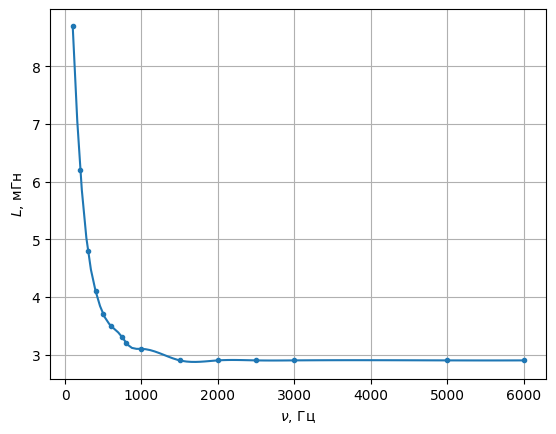

In [12]:
def interp(x, y):
    return UnivariateSpline(x, y, s=0)

def deriv(x, y):
    return UnivariateSpline(x, y, s=100).derivative()

raw_range = range(0, 15)

x = data_ind['nu'][raw_range]
y = data_ind['L'][raw_range]

L_max = max(y)
L_min = min(y)

print("L_max = {:.4f}, L_min = {:.4f}".format(L_max, L_min))

mipt.plot(x, y, func=interp)

plt.xlabel(r"$\nu$, Гц")
plt.ylabel(r"$L$, мГн")
plt.grid(True)

# plt.legend()
plt.savefig("gen/L_nu.pdf")




Be careful with inf. Will not interpolate.


cu_sigma = 1.991e+07


,<x>,sx,<y>,sy,rxy,a,da,b,db
0,345833.333333,9.745556e+10,10.043727,77.768383,2.743262e+06,0.000028,8.968508e-07,0.308916,0.417836


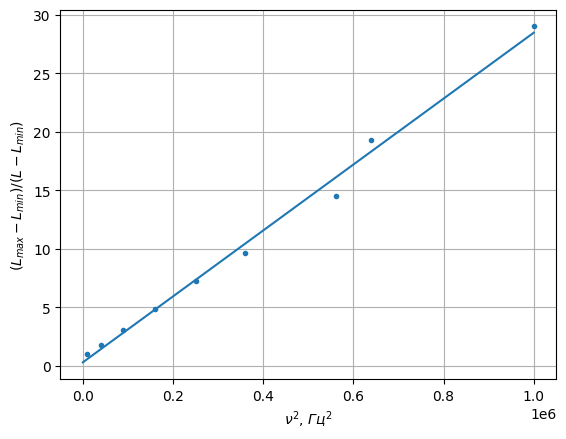

In [13]:
approx_range = range(0, 9)

x = data_ind['nu'][approx_range] ** 2
# print(x)
y = (L_max - L_min)/(data_ind['L'][approx_range] - L_min)
# print(y)

print("\n\nBe careful with inf. Will not interpolate.\n\n")

x_clean, y_clean, equ = mipt.plot(x, y, x_min=0)

plt.xlabel(r"$\nu^2$, $Гц^2$")
plt.ylabel(r"$(L_{max} - L_{min})/(L - L_{min})$")
plt.grid(True)

mnk_dat = mipt.mnk(x_clean, y_clean)

k = mnk_dat.get_data()['a'][0]

sigma_induct = k**0.5 / (setup.a * setup.h * consts.mu_0 * consts.pi)
print("cu_sigma = {:.4g}".format(sigma_induct))

# plt.legend()
plt.savefig("gen/LL_nu2.pdf")

mnk_dat.get_data()


## Summary

In [14]:
data_all = pd.concat([data_low, data_mid, data_high], ignore_index=True).drop(columns=['phi', 'ph', 'xi'])
data_all

,nu,I,U
0,20.0,438.800,134.5
1,30.0,436.600,198.7
2,40.0,432.500,259.5
3,50.0,427.300,315.8
4,60.0,421.400,367.6
5,70.0,415.200,414.7
6,80.0,408.800,457.0
7,90.0,402.500,495.0
8,100.0,396.300,528.6
9,110.0,390.300,555.8


In [15]:
H1_H0 = data_all['U'] / (data_all['nu'] * data_all['I'] * xi_0)
data_all.insert(loc=3, column='H1_H0', value=H1_H0)
data_all

,nu,I,U,H1_H0
0,20.0,438.800,134.5,0.995143
1,30.0,436.600,198.7,0.985038
2,40.0,432.500,259.5,0.973982
3,50.0,427.300,315.8,0.959774
4,60.0,421.400,367.6,0.944038
5,70.0,415.200,414.7,0.926485
6,80.0,408.800,457.0,0.907351
7,90.0,402.500,495.0,0.887272
8,100.0,396.300,528.6,0.866090
9,110.0,390.300,555.8,0.840596


In [16]:
def ln_h1_h0(nu, sigma):
    h = setup.h
    a = setup.a
    delta = 1 / (sigma * consts.mu_0 * consts.pi * nu) ** 0.5
    alpha = complex(1, 1) / delta
    return np.log(1 / abs(np.cosh(alpha * h) + 0.5*a*alpha * np.sinh(h * alpha)))

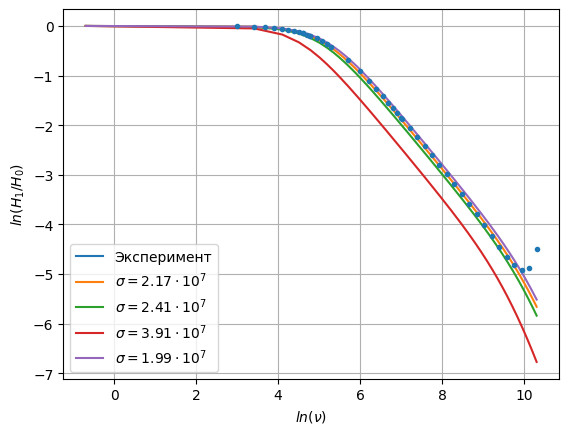

In [17]:
x = np.log(data_all['nu'])
y = np.log(data_all['H1_H0'])
# print(x)
# print(y)

# print("\n\nBe careful with inf. Will not interpolate.\n\n")

x_clean, y_clean, equ = mipt.plot(x, y, x_min=0, func=None, label="Эксперимент")

x_th = np.linspace(0.5, 30000, 1000)

plt.plot(np.log(x_th), ln_h1_h0(x_th, sigma_low), label="$\sigma = {:.3g}$".format(sigma_low).replace("e+0", " \cdot 10^"))
plt.plot(np.log(x_th), ln_h1_h0(x_th, sigma_mid), label="$\sigma = {:.3g}$".format(sigma_mid).replace("e+0", " \cdot 10^"))
plt.plot(np.log(x_th), ln_h1_h0(x_th, sigma_high), label="$\sigma = {:.3g}$".format(sigma_high).replace("e+0", " \cdot 10^"))
plt.plot(np.log(x_th), ln_h1_h0(x_th, sigma_induct), label="$\sigma = {:.3g}$".format(sigma_induct).replace("e+0", " \cdot 10^"))

plt.xlabel(r"$ln(\nu)$")
plt.ylabel(r"$ln(H_1 / H_0)$")
plt.grid(True)

# mnk_dat = mipt.mnk(x_clean, y_clean)

# k = mnk_dat.get_data()['a'][0]

# real_cu_sigma = k**0.5 / (setup.a * setup.h * consts.mu_0 * consts.pi)
# print("cu_sigma = {:.4g}".format(real_cu_sigma))

plt.legend()
plt.savefig("gen/summary.pdf")

# mnk_dat.get_data()


In [18]:
data = mipt.read_excel('data/351.ods', usecols=('E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'O', 'P', 'Q', 'R'), header=(0, 1)).dropna()

xsl = {
    "I=5 mA" : "5",
    "I=3 mA" : "3",
    "I=1.5 mA" : "1.5",

    "U_z, V" : "U_pos",
    "U_z_neg, V" : "U_neg",
    "I_z, mkA" : "I_pos",
    "I_z_neg, mkA" : "I_neg"
}

data = mipt.map_excel(data, xsl)
data

FileNotFoundError: [Errno 2] No such file or directory: 'data/351.ods'

1.5
	I_n = 25.9 mkA
	dI/dU(0) = 3.61 mkA/V
	left  dU = -7.18 V
	right dU = 7.17 V
	kT_e (I_n) = 3.59 eV
	kT_e (dU) = 3.59 eV
	T_e = 4.23e+04 K
	n_e = 2.19e+16 1/m^3
	omega_p = 8.29e+09 rad/s
	r_de = 0.00679 cm
	r_d = 0.000571 cm
	N_d = 17.1
	n = 6.36e+22 1/m^3
	alpha = 3.45e-07

3
	I_n = 53.2 mkA
	dI/dU(0) = 6.62 mkA/V
	left  dU = -8.03 V
	right dU = 8.04 V
	kT_e (I_n) = 4.02 eV
	kT_e (dU) = 4.02 eV
	T_e = 4.74e+04 K
	n_e = 4.25e+16 1/m^3
	omega_p = 1.15e+10 rad/s
	r_de = 0.00515 cm
	r_d = 0.00041 cm
	N_d = 12.3
	n = 6.36e+22 1/m^3
	alpha = 6.69e-07

5
	I_n = 94.8 mkA
	dI/dU(0) = 10.2 mkA/V
	left  dU = -9.58 V
	right dU = 9.1 V
	kT_e (I_n) = 4.67 eV
	kT_e (dU) = 4.67 eV
	T_e = 5.51e+04 K
	n_e = 7.03e+16 1/m^3
	omega_p = 1.48e+10 rad/s
	r_de = 0.00432 cm
	r_d = 0.000319 cm
	N_d = 9.55
	n = 6.36e+22 1/m^3
	alpha = 1.11e-06



,I_p,kT_e,n_e,omega_p,r_de,r_d,N_d,alpha
0,1.5,3.588937,2.189843e+10,8.286946e+09,0.006789,0.000571,17.111938,3.445061e-07
1,3.0,4.015897,4.251026e+10,1.154609e+10,0.005154,0.000410,12.281708,6.687715e-07
2,5.0,4.670910,7.027764e+10,1.484556e+10,0.004323,0.000319,9.552061,1.105608e-06


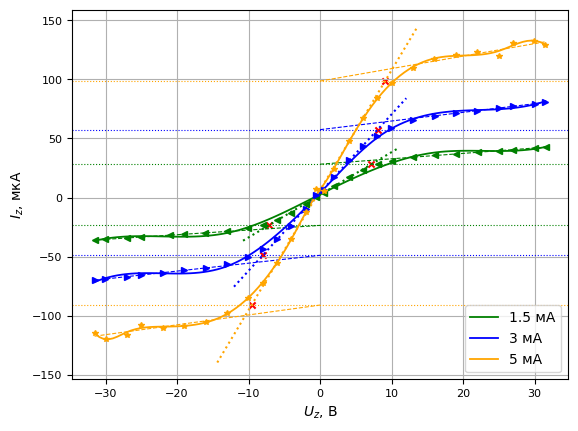

In [ ]:
from scipy import interpolate
import sympy as sp

# def interp(x, y):
#     return interpolate.interp1d(x, y, 'cubic')
def interp(x, y):
    return UnivariateSpline(x, y, s=100)

arr_T_e = []
arr_n_e = []
arr_I_p = []

lists = {
    'I_p' : [],
    'kT_e' : [],
    'n_e' : [],
    'omega_p' : [],
    'r_de' : [],
    'r_d' : [],
    'N_d' : [],
    'alpha' : []
}

def plot_zond(index, color, left, right, begin, end):
    x = np.concatenate((data[index, 'U_pos'], -data[index, 'U_neg']))
    y = np.concatenate((data[index, 'I_pos'], -data[index, 'I_neg']))

    lists['I_p'].append(float(index))
    print(index)

    x, y = sort_pairs(x, y, 0)
    
    mipt.plot(x, y, func=interp, color=color, label=index + " мА", unique_marker=True, marker_size=4, linewidth=1.3)
    
    # Asymptotes
    data_asl = [x[0:left], y[0:left]]
    data_asr = [x[len(x) - right:len(x)], y[len(y) - right:len(y)]]

    asl = mipt.interp_linear(data_asl[0], data_asl[1])
    asr = mipt.interp_linear(data_asr[0], data_asr[1])
    
    mipt.plot(data_asl[0], data_asl[1],
              color=color, linestyle='dashed', x_min=min(x), x_max=0, linewidth = 0.8, unique_marker=' ')

    mipt.plot(data_asr[0], data_asr[1],
              color=color, linestyle='dashed', x_min=0, x_max=max(x), linewidth = 0.8, unique_marker=' ')

    I_n = np.average([-asl(0), asr(0)])
    print("\tI_n = {:.3} mkA".format(I_n))

    # Tangent
    begin += len(x)//2
    end   += len(x)//2

    data_tan = [x[begin:end], y[begin:end]]
    tan = mipt.interp_linear(data_tan[0], data_tan[1])

    dI_dU = (tan(1) - tan(0)) / 1
    print("\tdI/dU(0) = {:.3} mkA/V".format(dI_dU))

    # Intersection
    line_tan = sp.Line((0, tan(0)), (1, tan(1)))
    line_Il = sp.Line((0, asl(0)), (1, asl(0)))
    line_Ir = sp.Line((0, asr(0)), (1, asr(0)))

    inter_l = line_tan.intersection(line_Il)[0]
    inter_r = line_tan.intersection(line_Ir)[0]

    dU_l = float(inter_l.x)
    dU_r = float(inter_r.x)
    print("\tleft  dU = {:.3} V".format(dU_l))
    print("\tright dU = {:.3} V".format(dU_r))

    # Tangent
    mipt.plot(data_tan[0], data_tan[1], color=color, linestyle='dotted', unique_marker=' ',
              x_min=1.5 * float(inter_l.x), x_max=1.5 * float(inter_r.x))

    # Horizontal on I_n
    plt.axhline(y=asl(0), color=color, linewidth=0.8, linestyle='dotted')
    plt.axhline(y=asr(0), color=color, linewidth=0.8, linestyle='dotted')

    # Intersections
    plt.scatter(x=inter_r.x, y=inter_r.y, color='r', marker='x', s=20)
    plt.scatter(x=inter_l.x, y=inter_l.y, color='r', marker='x', s=20)

    kT_e1 = 0.5 * I_n / dI_dU
    print("\tkT_e (I_n) = {:.3} eV".format(kT_e1))
    kT_e2 = 0.5 * np.average([-dU_l, dU_r])
    print("\tkT_e (dU) = {:.3} eV".format(kT_e2))

    lists['kT_e'].append(kT_e1)

    T_e = kT_e1 * 11800
    print("\tT_e = {:.3} K".format(T_e))

    n_e = (I_n * 10**-6) / (0.4 * consts.e * setup.S * 10**-6) * np.sqrt(setup.m_i / (2 * consts.k * T_e))
    print("\tn_e = {:.3} 1/m^3".format(n_e))
    lists['n_e'].append(n_e / 100**3)

    omega_p = 5.6 * 10**4 * np.sqrt(n_e / 100**3)
    print("\tomega_p = {:.3} rad/s".format(omega_p))
    lists['omega_p'].append(omega_p)

    r_de = np.sqrt(cgs.k * T_e / (8 * consts.pi * n_e / 100**3)) / cgs.e #CGS
    print("\tr_de = {:.3} cm".format(r_de))
    lists['r_de'].append(r_de)

    T_i = 300 # K
    r_d = np.sqrt(cgs.k * T_i / (8 * consts.pi * n_e / 100**3)) / cgs.e #CGS
    print("\tr_d = {:.3} cm".format(r_d))
    lists['r_d'].append(r_d)

    N_d = 4/3 * consts.pi * r_d**3 * (n_e / 100**3) # n_i = n_e
    print("\tN_d = {:.3}".format(N_d))
    lists['N_d'].append(N_d)

    n = (2/760 * 10**5) / (consts.k * T_i)
    print("\tn = {:.3} 1/m^3".format(n))

    alpha = n_e / n
    print("\talpha = {:.3}".format(alpha))
    lists['alpha'].append(alpha)

    arr_T_e.append(T_e)
    arr_n_e.append(n_e)

    print("")

    
plot_zond("1.5", 'Green', 4, 4, -4, 4)
plot_zond("3", 'Blue', 4, 4, -4, 4)
plot_zond("5", 'Orange', 5, 5, -4, 4)

arr_I_p.append(1.5)
arr_I_p.append(3)
arr_I_p.append(5)

plt.xlabel(r"$U_z$, В")
plt.ylabel(r"$I_z$, мкА")
plt.grid(True)

plt.legend()
plt.savefig('gen/Iz_Uz.pdf')

results = pd.DataFrame.from_dict(lists)
results

In [ ]:
lists = {
    'I_p' : [],
    'kT_e' : [],
    'n_e' : [],
    'omega_p' : [],
    'r_de' : [],
    'r_d' : [],
    'N_d' : [],
    'alpha' : []
}


fmt = {
    'I_p' :  [r'$I_p$, мА', '{:.1f}'],
    'kT_e' :  [r'$kT_e$, эВ', '{:.1f}'],
    'n_e' :  [r'$n_e \cdot 10^{-9}$, $1 / \text{см}^3$', '{:.1f}', -9],
    'omega_p' :  [r'$\omega_p \cdot 10^{-9}$, рад/с', '{:.1f}', -9],
    'r_de' :  [r'$r_{De}$, мкм', '{:.2f}', 4],
    'r_d' :  [r'$r_{D}$, мкм', '{:.2f}', 4],
    'N_d' :  [r'$N_{d}$', '{:.1f}'],
    'alpha' :  [r'$\alpha \cdot 10^6$', '{:.3f}', 6],
}

# names_list = [fmt.get(item, item) for item in fmt]

# dat = pd.DataFrame({"-" : names_list, "ferrit" : ferrit_list, "fesi" : fesi_list, "feni" : feni_list})
# dat = dat.set_index('-').transpose()
# dat.insert(0, '--', ['Феррит (Fe-Ni-Zn)', 'Fe-Si', 'Fe-Ni'])

tab = mipt.table(results, fmt)
tab.rename().data
tab.to_latex('gen/tab_res.tex')
results

,I_p,kT_e,n_e,omega_p,r_de,r_d,N_d,alpha
0,1.5,3.588937,2.189843e+10,8.286946e+09,0.006789,0.000571,17.111938,3.445061e-07
1,3.0,4.015897,4.251026e+10,1.154609e+10,0.005154,0.000410,12.281708,6.687715e-07
2,5.0,4.670910,7.027764e+10,1.484556e+10,0.004323,0.000319,9.552061,1.105608e-06


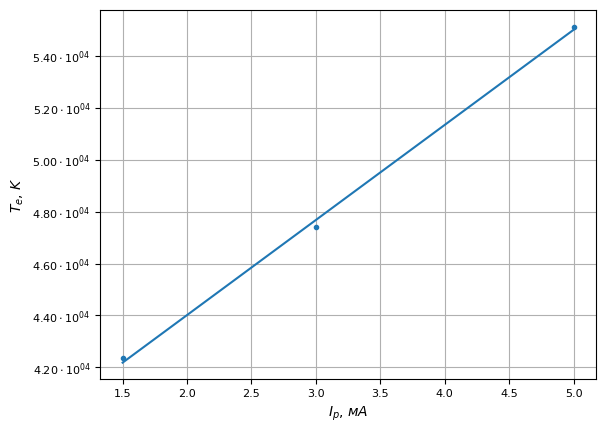

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()

mipt.plot(arr_I_p, arr_T_e)

def yfmt(arg, dummy):
    return '${:.2e} }}$'.format(arg).replace('e+', '\cdot 10^{')

# Convert to scientific notation
ax.yaxis.set_major_formatter(ticker.FuncFormatter(yfmt))
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

plt.xlabel(r"$I_p$, $мА$")
plt.ylabel(r"$T_e$, $K$")
plt.grid(True)

# plt.legend()
plt.savefig('gen/T_e_I_p.pdf', pad_inches=0.3, bbox_inches='tight')


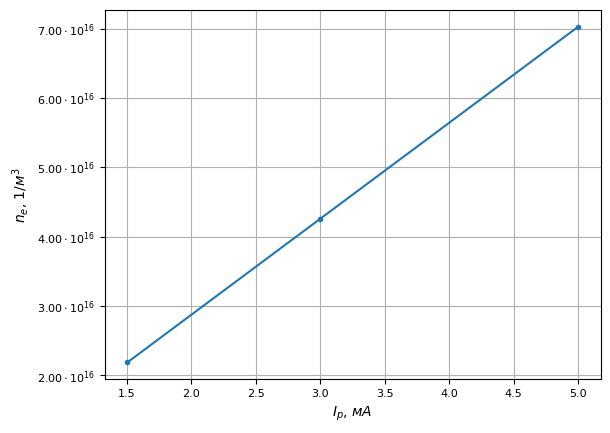

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()

mipt.plot(arr_I_p, arr_n_e)

def yfmt(arg, dummy):
    return '${:.2e} }}$'.format(arg).replace('e+', '\cdot 10^{')

# Convert to scientific notation
ax.yaxis.set_major_formatter(ticker.FuncFormatter(yfmt))
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

plt.xlabel(r"$I_p$, $мА$")
plt.ylabel(r"$n_e$, $1/м^3$")
plt.grid(True)

# plt.legend()
plt.savefig('gen/n_e_I_p.pdf', pad_inches=0.3, bbox_inches='tight')

In [ ]:
print("{:.2e}".format( 25 * 10**-6 / (0.4 * 1.6 * 10**-19 * 0.0002 * 0.0052 * 3.14) * (22 * 1.66 * 10**-27 / (2 * 1.38 * 10**-23 * 40000))**0.5 ))

2.18e+16


In [ ]:
setup.S

3.2672556800000003